In [1]:
# import modules
%matplotlib inline

import os
import pylab
import random
import numpy as np
import pandas as pd
import cPickle as pkl
from skimage.util import crop
from skimage import transform
from scipy.misc import imread, imresize
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from lasagne import layers, updates, nonlinearities, objectives
from nolearn.lasagne import NeuralNet, BatchIterator, visualize, TrainSplit

data_root = os.path.join(os.path.expanduser('~'), 'workspace/right_whale/data')

data_size = 11468

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
# load train
train = pd.read_csv(os.path.join(data_root, 'train.csv'))
test = pd.read_csv(os.path.join(data_root, 'sample_submission.csv'))

In [3]:
train.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


In [4]:
test.head()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
0,w_1947.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,w_11096.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,w_10973.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,w_10442.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,w_10606.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


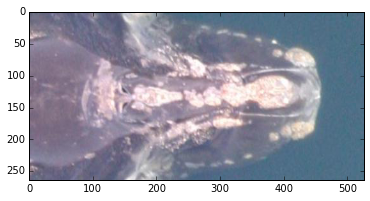

In [5]:
# visualize crop
pylab.imshow(imread(os.path.join(data_root, 'traincrops', train.ix[0, 0])))

In [7]:
# create data for train and test
data_x = []
for item in train.Image:
    img = imread(os.path.join(data_root, 'traincrops', item))
    img = imresize(img, (64, 64))
    img = np.transpose(img, (2, 0, 1))
    data_x.append(img.astype('float32'))

data_x = np.stack(data_x)
print data_x.shape

data_y = train.whaleID.values
lb = LabelEncoder()
lb.fit(np.unique(data_y));
y = (lb.transform(data_y) + 1).astype('int32')

data_x_test = []

(4544, 3, 64, 64)


In [8]:
#data_x /= data_x.std(axis = None)
data_x -= data_x.mean(axis = None)

In [9]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool4', layers.MaxPool2DLayer),
        ('dropout5', layers.DropoutLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 3, 64, 64),
    conv1_num_filters = 512, conv1_filter_size = 11,
    pool2_pool_size = 4,
    conv3_num_filters = 512, conv3_filter_size = 10,
    pool4_pool_size = 4,
    dropout5_p = 0.2,
    output_num_units = 447, output_nonlinearity = nonlinearities.softmax,

    batch_iterator_train = BatchIterator(batch_size = 32),
    batch_iterator_test = BatchIterator(batch_size = 10),
    train_split=TrainSplit(0.15,stratify=False),

    update=updates.adam,
    
    objective_l2=1e-5,

    regression = False,
    max_epochs = 300,
    verbose = 1,
)

In [10]:
net.fit(data_x, y);

# Neural Network with 26630591 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     3x64x64
  1  conv1     512x54x54
  2  pool2     512x13x13
  3  conv3     512x4x4
  4  pool4     512x1x1
  5  dropout5  512x1x1
  6  output    447

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1      26.80652       6.08694      4.40394      0.01077  28.01s
      2       6.08693       6.07600      1.00180      0.01077  27.85s
      3       6.17265       6.06701      1.01741      0.01077  28.60s
      4       6.05483       6.05816      0.99945      0.01077  28.85s
      5       6.04220       6.05016      0.99869      0.01077  29.03s
      6       6.03051       6.04292      0.99795      0.01077  28.86s
      7       6.02437       6.03647      0.99800      0.01077  29.08s
      8       6.00970       6.03056      0.99654      0.01077  28.88s
      9       6.00035

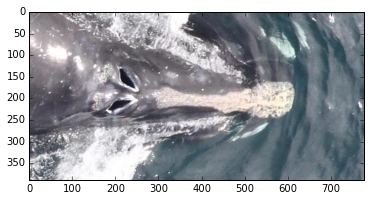

In [14]:
# visualize crop
pylab.imshow(imread(os.path.join(data_root, 'testcrops', test.ix[0, 0])))

In [18]:
# create data for train and test
data_x_test = []
for item in test.Image:
    img = imread(os.path.join(data_root, 'testcrops', item))
    img = imresize(img, (64, 64))
    img = np.transpose(img, (2, 0, 1))
    data_x_test.append(img.astype('float32'))

data_x_test = np.stack(data_x_test)
print data_x_test.shape

(6925, 3, 64, 64)


In [21]:
data_x_test -= data_x_test.mean(axis = None)

In [22]:
pred = net.predict(data_x_test)

In [23]:
test.whale_00195 = 0
for i, j in enumerate(pred):
    test.ix[i, j] = 1
    
test.to_csv('sub01.csv', index = False)

In [ ]:
testcrop = 

In [30]:
y.astype('int32')

array([223,  45, 204, ..., 254, 110, 295], dtype=int32)